Date: 08/17/2020 | Author: Joao Antunes

### Bicycle model
In this notebook you will find an implementation of a bicycle model for our truck.

The equations here obtained from: R. N. Jazar. Vehicle Dynamics:
Theory and Application. Springer, 2nd edition, 2014. ISBN:978-1-4614-8544-5
Chapter 10 - Vehicle Planar Dynamics Section 10.4

For a more detailed explanation about this model and study please refer to: https://confluence.outrider.ai/display/SIT/Simulation


In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
class Results:
    """
    Create a results class so that I can tied up the results in a class.
    """
    def __init__(self):
        self.t = 0
        self.vx = 0
        self.yaw_dot = 0
        self.vy = 0
        self.slip_angle_f = 0
        self.slip_angle_r = 0
        self.yaw_dot_dot = 0
        self.ay = 0
        self.Fy_f = 0
        self.Fy_r = 0
        self.corner_radius = 0

class OneTrack:
    def __init__(self):
        # The values were obtained from https://confluence.outrider.ai/display/SIT/Vehicle+properties
        self.Izz        = 16840     # Kg.m^2
        self.m          = 8600      # Kg
        self.C_alpha_f  = 197705    # N/rad
        self.C_alpha_r  = 197705    # N/rad
        self.WD         = 60        #%
        self.wheelbase  = 3.1       #m

In [3]:
def run_simulation(vx_i, steer_i, one_track: OneTrack):
    """
    Simulates the vehicle model
    :param vx_i: Longitudinal velocity of the truck in m/s
    :param steer_i: Steering input in rad
    :param one_track: Truck model
    :return: Results class
    """

    # Pass vehicle properties to local variable
    Izz = one_track.Izz
    m = one_track.m
    C_alpha_f = one_track.C_alpha_f
    C_alpha_r = one_track.C_alpha_r
    wheelbase = one_track.wheelbase
    WD = one_track.WD


    ####################################################################################################################
    # Simulation Settings
    t = 0.01 # s
    simulation_time = 2 # s

    ####################################################################################################################
    # Define Input
    #steering_at_wheel = np.ones([int(simulation_time/t)])*steer_i
    steering_at_wheel = np.concatenate((np.ones([int(simulation_time/2/t)])*0, np.ones([int(simulation_time/2/t)])*steer_i))

    # Intermediate Calculations
    a1 = (1-WD/100) * wheelbase
    b1 = WD/100 * wheelbase

    ####################################################################################################################
    # Initialize simulation arrays. This will be during the simulation to save the vehicle state
    vy_arr = np.empty([int(simulation_time/t)])
    yaw_dot_arr = np.empty([int(simulation_time/t)])
    slip_angle_r_arr = np.empty([int(simulation_time/t)])
    slip_angle_f_arr = np.empty([int(simulation_time/t)])
    yaw_dot_dot_arr = np.empty([int(simulation_time/t)])
    ay_arr = np.empty([int(simulation_time/t)])
    Fy_1_arr = np.empty([int(simulation_time/t)])
    Fy_2_arr = np.empty([int(simulation_time/t)])

    ####################################################################################################################
    # Simulation Initial Conditions
    vx = vx_i
    vy = 0
    yaw_dot = 0

    ####################################################################################################################
    # Simulation
    for i in range(1, int(simulation_time/t+1)):
        
        # Slip angle Calculations
        slip_angle_1 = (steering_at_wheel[i-1] - (vy + a1*yaw_dot)/vx)
        slip_angle_2 = ((b1*yaw_dot - vy)/vx)

        # Lateral Force calculations
        Fy_1 = C_alpha_f * slip_angle_1
        Fy_2 = C_alpha_r * slip_angle_2

        # Accelerations calculations
        ay = (Fy_1 * math.cos(steering_at_wheel[i-1]) + Fy_2)/m - yaw_dot*vx
        yaw_dot_dot = (a1*Fy_1*math.cos(steering_at_wheel[i-1]) - b1*Fy_2)/Izz

        # Save Sim results
        vy_arr[i-1] = vy
        yaw_dot_arr[i-1] = yaw_dot
        slip_angle_r_arr[i-1] = slip_angle_2
        slip_angle_f_arr[i-1] = slip_angle_1
        yaw_dot_dot_arr[i-1] = yaw_dot_dot
        ay_arr[i-1] = ay + yaw_dot*vx
        Fy_1_arr[i-1] = Fy_1
        Fy_2_arr[i-1] = Fy_2

        # Integrate next step
        vy = ay*t + vy
        yaw_dot = yaw_dot_dot*t + yaw_dot


    ####################################################################################################################
    # Results
    ti = np.arange(0, simulation_time, t)

    result = Results()
    result.t = ti
    result.ay = (ay_arr+ yaw_dot_arr*vx) # Convert to global coordinates
    result.vx = vx
    result.Fy_f = Fy_1_arr
    result.Fy_r = Fy_2_arr
    result.slip_angle_f = slip_angle_f_arr
    result.slip_angle_r = slip_angle_r_arr
    result.yaw_dot = yaw_dot_arr
    result.yaw_dot_dot = yaw_dot_dot_arr
    result.vy = vy_arr

    # Additional Outputs
    result.corner_radius = result.vx / result.yaw_dot

    return result


### Analysis

The following section simulates the truck based on the model described before.
In this workbook we did two studies:

    1 - Step study
    2 - Sensitivity study

<ipython-input-3-0f6e1d0e33eb>:98: RuntimeWarning: divide by zero encountered in true_divide
  result.corner_radius = result.vx / result.yaw_dot


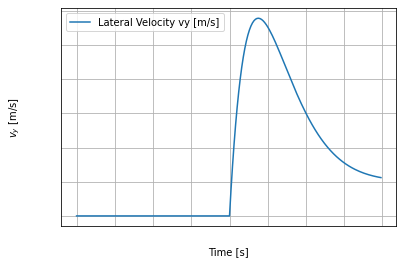

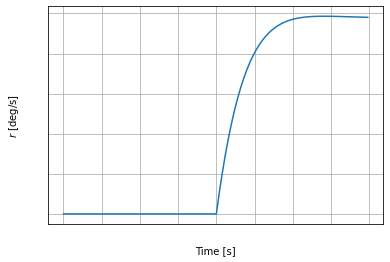

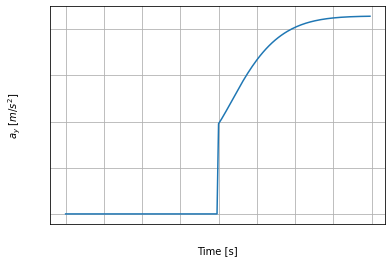

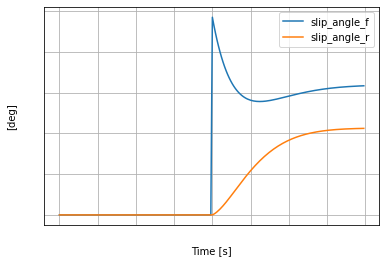

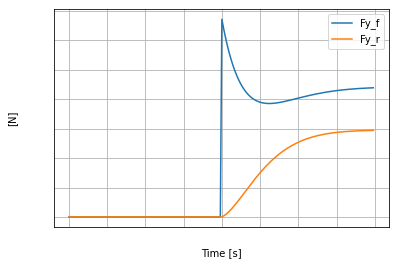

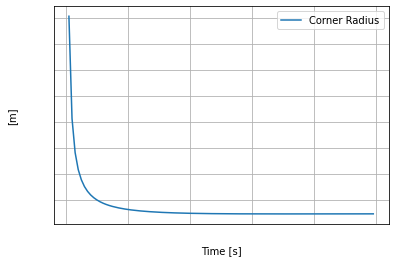

In [4]:
# Init model
one_t = OneTrack()

# Run the model at 10m/s and a steering input of 0.017rad (1deg) at the wheels.
sim_result = run_simulation(10, 0.017,one_t)

# Analyze results
plt.figure()
plt.plot(sim_result.t, sim_result.vy)
plt.xlabel("Time [s]")
plt.ylabel("$v_y$ [m/s]")
plt.legend(["Lateral Velocity vy [m/s]"])
plt.grid(True)
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')


plt.figure()
plt.plot(sim_result.t, sim_result.yaw_dot*57)
plt.xlabel("Time [s]")
plt.ylabel("$r$ [deg/s]")
plt.grid(True)
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')


plt.figure()
plt.plot(sim_result.t, sim_result.ay)
plt.xlabel("Time [s]")
plt.ylabel("$a_y$ [$m/s^2$]")
plt.grid(True)
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')


plt.figure()
plt.plot(sim_result.t, sim_result.slip_angle_f*57)
plt.plot(sim_result.t, sim_result.slip_angle_r*57) # convert from rad to deg
plt.xlabel("Time [s]")
plt.ylabel("[deg]")
plt.legend(["slip_angle_f","slip_angle_r"])
plt.grid(True)
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')


plt.figure()
plt.plot(sim_result.t, sim_result.Fy_f)
plt.plot(sim_result.t, sim_result.Fy_r)
plt.xlabel("Time [s]")
plt.ylabel("[N]")
plt.legend(["Fy_f","Fy_r"])
plt.grid(True)
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')


plt.figure()
plt.plot(sim_result.t, sim_result.corner_radius)
plt.xlabel("Time [s]")
plt.ylabel("[m]")
plt.legend(["Corner Radius"])
plt.grid(True)
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

<ipython-input-3-0f6e1d0e33eb>:98: RuntimeWarning: divide by zero encountered in true_divide
  result.corner_radius = result.vx / result.yaw_dot


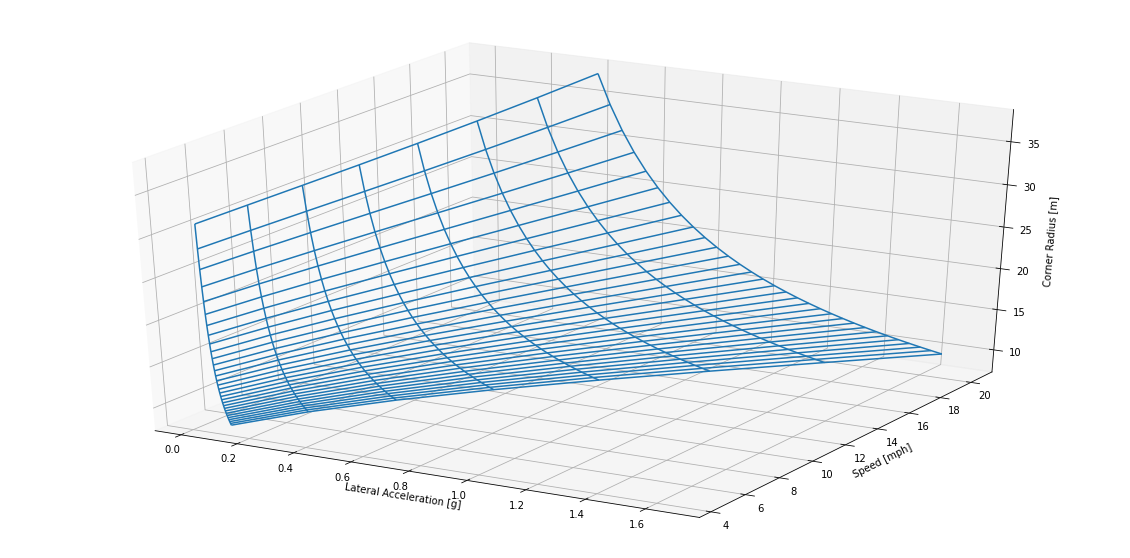

In [5]:
# Run a batch simulation with vehicle:
# * Speed: 2-10m/s with a step of 1
# * Steering Angle: 0.1-0.4rad with a step of 0.01

vx_length = np.arange(2,10,1)
steer_length = np.arange(0.1,0.4,0.01)
ay = np.zeros((vx_length.size, steer_length.size))
corner_radius=np.zeros((vx_length.size, steer_length.size))
v=np.zeros((vx_length.size, steer_length.size))

for i, vx_i in enumerate(vx_length):
    for j, steer in enumerate(steer_length):
        sim_results = run_simulation(vx_i, steer,one_t)
        corner_radius[i][j] = (sim_results.vx/sim_results.yaw_dot[-1])
        ay[i][j] = sim_results.ay[-1]
        v[i][j] = sim_results.vx


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("Lateral Acceleration [g]")
ax.set_ylabel("Speed [mph]")
ax.set_zlabel("Corner Radius [m]")
ax.plot_wireframe(ay/9.8, v*3.6/1.6, corner_radius)

### Sensitivity Study
In this section we will be running sensitivity analysis. We will sweep the following parameters:
* Mass
* Front cornering stiffness
* Rear cornering stiffness
* Weight distribution
* Inertia

Blue color is the default vehicle, orange is the vehicle with the modified parameter.

<ipython-input-3-0f6e1d0e33eb>:98: RuntimeWarning: divide by zero encountered in true_divide
  result.corner_radius = result.vx / result.yaw_dot


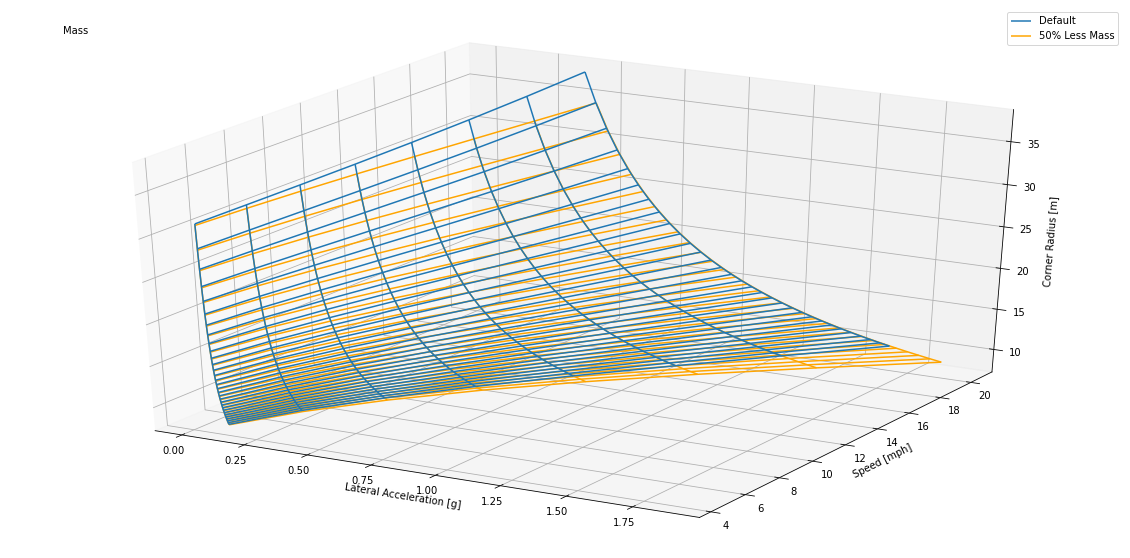

In [6]:
# Default Vehicle
one_t = OneTrack()
vx_length = np.arange(2,10,1)
steer_length = np.arange(0.1,0.4,0.01)
ay = np.zeros((vx_length.size, steer_length.size))
corner_radius=np.zeros((vx_length.size, steer_length.size))
v=np.zeros((vx_length.size, steer_length.size))

for i, vx_i in enumerate(vx_length):
    for j, steer in enumerate(steer_length):
        sim_results = run_simulation(vx_i, steer, one_t)
        corner_radius[i][j] = (sim_results.vx/sim_results.yaw_dot[-1])
        ay[i][j] = sim_results.ay[-1]
        v[i][j] = sim_results.vx


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("Lateral Acceleration [g]")
ax.set_ylabel("Speed [mph]")
ax.set_zlabel("Corner Radius [m]")
ax.plot_wireframe(ay/9.8, v*3.6/1.6, corner_radius, label="Default")

# 50% Less
one_t = OneTrack()
one_t.m = one_t.m*0.50
vx_length = np.arange(2,10,1)
steer_length = np.arange(0.1,0.4,0.01)
ay = np.zeros((vx_length.size, steer_length.size))
corner_radius=np.zeros((vx_length.size, steer_length.size))
v=np.zeros((vx_length.size, steer_length.size))
for i, vx_i in enumerate(vx_length):
    for j, steer in enumerate(steer_length):
        sim_results = run_simulation(vx_i, steer, one_t)
        corner_radius[i][j] = (sim_results.vx/sim_results.yaw_dot[-1])
        ay[i][j] = sim_results.ay[-1]
        v[i][j] = sim_results.vx

ax.plot_wireframe(ay/9.8, v*3.6/1.6, corner_radius, color='orange', label="50% Less Mass")
ax.text2D(0.05, 0.95, "Mass", transform=ax.transAxes)
ax.legend()

<ipython-input-3-0f6e1d0e33eb>:98: RuntimeWarning: divide by zero encountered in true_divide
  result.corner_radius = result.vx / result.yaw_dot


Text(0.05, 0.95, 'Front Cornering Stiffness')

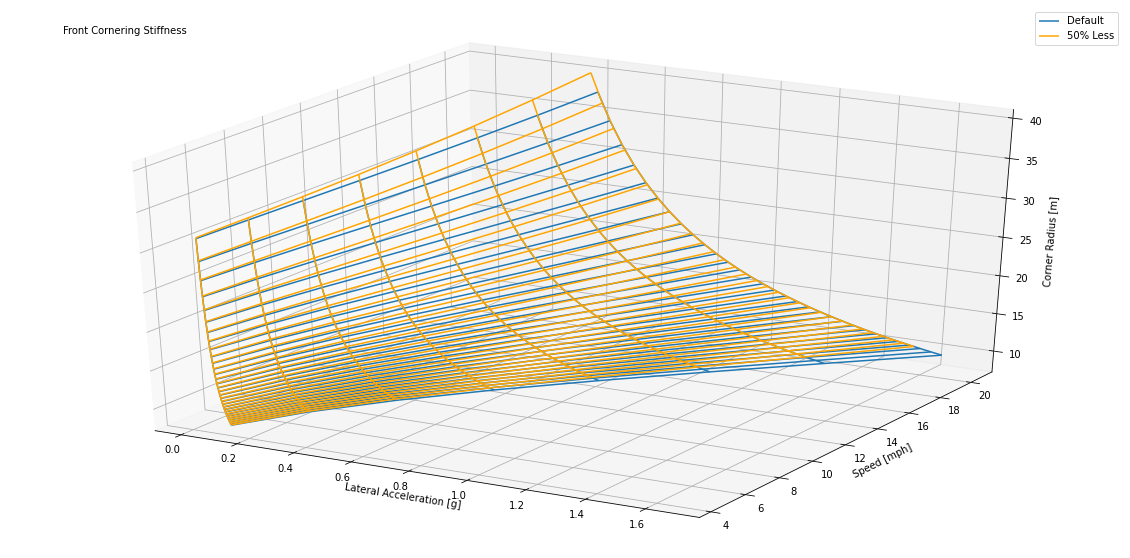

In [7]:
# Default Vehicle
one_t = OneTrack()
vx_length = np.arange(2,10,1)
steer_length = np.arange(0.1,0.4,0.01)
ay = np.zeros((vx_length.size, steer_length.size))
corner_radius=np.zeros((vx_length.size, steer_length.size))
v=np.zeros((vx_length.size, steer_length.size))
for i, vx_i in enumerate(vx_length):
    for j, steer in enumerate(steer_length):
        sim_results = run_simulation(vx_i, steer, one_t)
        corner_radius[i][j] = (sim_results.vx/sim_results.yaw_dot[-1])
        ay[i][j] = sim_results.ay[-1]
        v[i][j] = sim_results.vx


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("Lateral Acceleration [g]")
ax.set_ylabel("Speed [mph]")
ax.set_zlabel("Corner Radius [m]")
ax.plot_wireframe(ay/9.8, v*3.6/1.6, corner_radius, label="Default")


# 50% Less
one_t = OneTrack()
one_t.C_alpha_f = one_t.C_alpha_f*0.90
vx_length = np.arange(2,10,1)
steer_length = np.arange(0.1,0.4,0.01)
ay = np.zeros((vx_length.size, steer_length.size))
corner_radius=np.zeros((vx_length.size, steer_length.size))
v=np.zeros((vx_length.size, steer_length.size))
for i, vx_i in enumerate(vx_length):
    for j, steer in enumerate(steer_length):
        sim_results = run_simulation(vx_i, steer, one_t)
        corner_radius[i][j] = (sim_results.vx/sim_results.yaw_dot[-1])
        ay[i][j] = sim_results.ay[-1]
        v[i][j] = sim_results.vx


ax.plot_wireframe(ay/9.8, v*3.6/1.6, corner_radius, color='orange', label="50% Less")
ax.legend()
ax.text2D(0.05, 0.95, "Front Cornering Stiffness", transform=ax.transAxes)

<ipython-input-3-0f6e1d0e33eb>:98: RuntimeWarning: divide by zero encountered in true_divide
  result.corner_radius = result.vx / result.yaw_dot


Text(0.05, 0.95, 'Rear Cornering Stiffness')

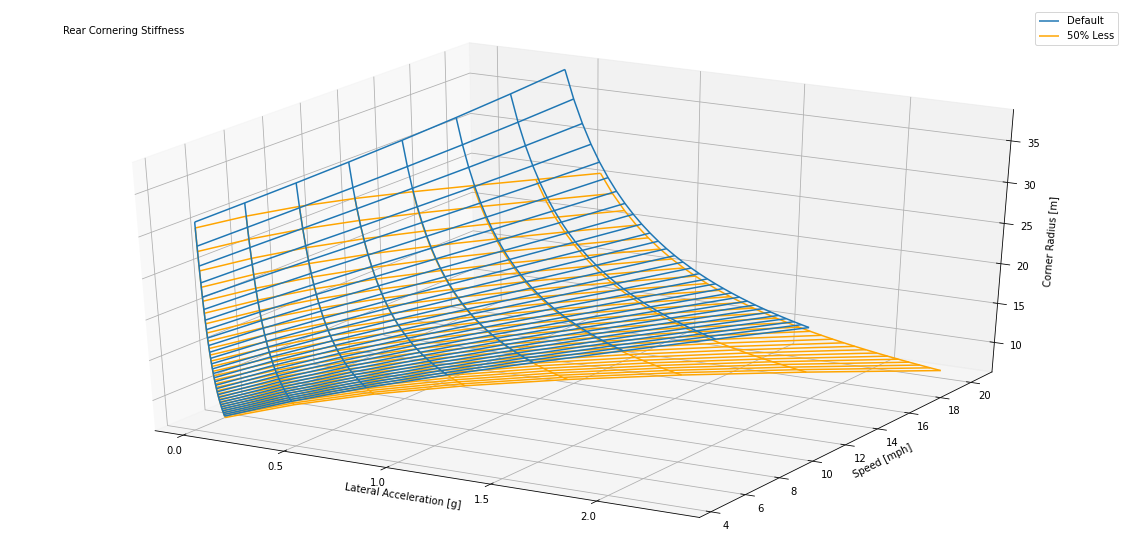

In [8]:
# Default vehicle
one_t = OneTrack()
vx_length = np.arange(2,10,1)
steer_length = np.arange(0.1,0.4,0.01)
ay = np.zeros((vx_length.size, steer_length.size))
corner_radius=np.zeros((vx_length.size, steer_length.size))
v=np.zeros((vx_length.size, steer_length.size))
for i, vx_i in enumerate(vx_length):
    for j, steer in enumerate(steer_length):
        sim_results = run_simulation(vx_i, steer, one_t)
        corner_radius[i][j] = (sim_results.vx/sim_results.yaw_dot[-1])
        ay[i][j] = sim_results.ay[-1]
        v[i][j] = sim_results.vx


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("Lateral Acceleration [g]")
ax.set_ylabel("Speed [mph]")
ax.set_zlabel("Corner Radius [m]")
ax.plot_wireframe(ay/9.8, v*3.6/1.6, corner_radius, label="Default")

# 50% Less
one_t = OneTrack()
one_t.C_alpha_r = one_t.C_alpha_r*0.50
vx_length = np.arange(2,10,1)
steer_length = np.arange(0.1,0.4,0.01)
ay = np.zeros((vx_length.size, steer_length.size))
corner_radius=np.zeros((vx_length.size, steer_length.size))
v=np.zeros((vx_length.size, steer_length.size))
for i, vx_i in enumerate(vx_length):
    for j, steer in enumerate(steer_length):
        sim_results = run_simulation(vx_i, steer, one_t)
        corner_radius[i][j] = (sim_results.vx/sim_results.yaw_dot[-1])
        ay[i][j] = sim_results.ay[-1]
        v[i][j] = sim_results.vx

ax.plot_wireframe(ay/9.8, v*3.6/1.6, corner_radius, color='orange', label="50% Less")
ax.legend()
ax.text2D(0.05, 0.95, "Rear Cornering Stiffness", transform=ax.transAxes)

<ipython-input-3-0f6e1d0e33eb>:98: RuntimeWarning: divide by zero encountered in true_divide
  result.corner_radius = result.vx / result.yaw_dot


Text(0.05, 0.95, 'Weight Distribution')

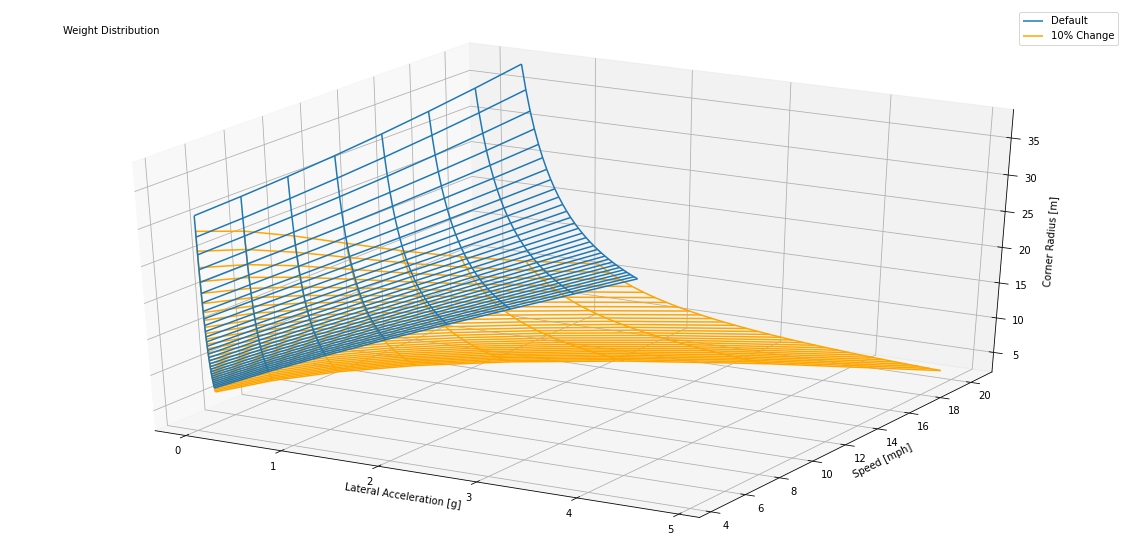

In [9]:
# Default Vehicle
one_t = OneTrack()
vx_length = np.arange(2,10,1)
steer_length = np.arange(0.1,0.4,0.01)
ay = np.zeros((vx_length.size, steer_length.size))
corner_radius=np.zeros((vx_length.size, steer_length.size))
v=np.zeros((vx_length.size, steer_length.size))
for i, vx_i in enumerate(vx_length):
    for j, steer in enumerate(steer_length):
        sim_results = run_simulation(vx_i, steer, one_t)
        corner_radius[i][j] = (sim_results.vx/sim_results.yaw_dot[-1])
        ay[i][j] = sim_results.ay[-1]
        v[i][j] = sim_results.vx

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("Lateral Acceleration [g]")
ax.set_ylabel("Speed [mph]")
ax.set_zlabel("Corner Radius [m]")
ax.plot_wireframe(ay/9.8, v*3.6/1.6, corner_radius, label="Default")


# 50% Less
one_t = OneTrack()
one_t.WD = 0.40
vx_length = np.arange(2,10,1)
steer_length = np.arange(0.1,0.4,0.01)
ay = np.zeros((vx_length.size, steer_length.size))
corner_radius=np.zeros((vx_length.size, steer_length.size))
v=np.zeros((vx_length.size, steer_length.size))
for i, vx_i in enumerate(vx_length):
    for j, steer in enumerate(steer_length):
        sim_results = run_simulation(vx_i, steer, one_t)
        corner_radius[i][j] = (sim_results.vx/sim_results.yaw_dot[-1])
        ay[i][j] = sim_results.ay[-1]
        v[i][j] = sim_results.vx

ax.plot_wireframe(ay/9.8, v*3.6/1.6, corner_radius, color='orange', label="10% Change")
ax.legend()
ax.text2D(0.05, 0.95, "Weight Distribution", transform=ax.transAxes)


<ipython-input-3-0f6e1d0e33eb>:98: RuntimeWarning: divide by zero encountered in true_divide
  result.corner_radius = result.vx / result.yaw_dot


Text(0.05, 0.95, 'Inertia')

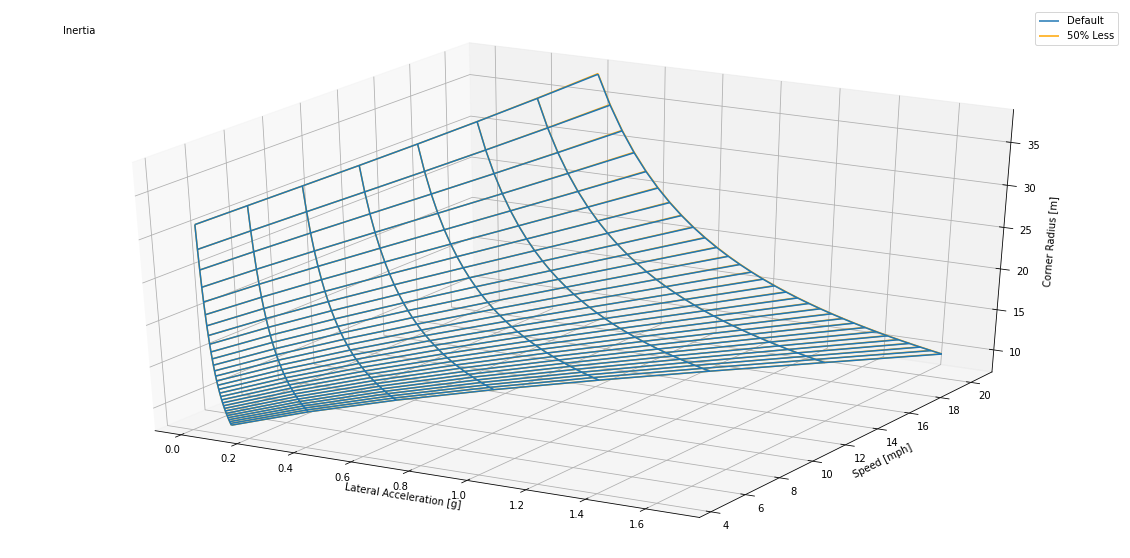

In [10]:
# Default Vehicle
one_t = OneTrack()
vx_length = np.arange(2,10,1)
steer_length = np.arange(0.1,0.4,0.01)
ay = np.zeros((vx_length.size, steer_length.size))
corner_radius=np.zeros((vx_length.size, steer_length.size))
v=np.zeros((vx_length.size, steer_length.size))
for i, vx_i in enumerate(vx_length):
    for j, steer in enumerate(steer_length):
        sim_results = run_simulation(vx_i, steer, one_t)
        corner_radius[i][j] = (sim_results.vx/sim_results.yaw_dot[-1])
        ay[i][j] = sim_results.ay[-1]
        v[i][j] = sim_results.vx

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("Lateral Acceleration [g]")
ax.set_ylabel("Speed [mph]")
ax.set_zlabel("Corner Radius [m]")
ax.plot_wireframe(ay/9.8, v*3.6/1.6, corner_radius, label="Default")


# 50% Less
one_t = OneTrack()
one_t.Izz = one_t.Izz*0.5
vx_length = np.arange(2,10,1)
steer_length = np.arange(0.1,0.4,0.01)
ay = np.zeros((vx_length.size, steer_length.size))
corner_radius=np.zeros((vx_length.size, steer_length.size))
v=np.zeros((vx_length.size, steer_length.size))
for i, vx_i in enumerate(vx_length):
    for j, steer in enumerate(steer_length):
        sim_results = run_simulation(vx_i, steer, one_t)
        corner_radius[i][j] = (sim_results.vx/sim_results.yaw_dot[-1])
        ay[i][j] = sim_results.ay[-1]
        v[i][j] = sim_results.vx

ax.plot_wireframe(ay/9.8, v*3.6/1.6, corner_radius, color='orange', label="50% Less")
ax.legend()
ax.text2D(0.05, 0.95, "Inertia", transform=ax.transAxes)



In [11]:

print(      '{:^15} | {:^15} | {:^15} | {:^15} | {:^15} | {:^15} | {:^15}  | {:^15}| {:^15}'
      .format("Steering (deg)","Vx (m/s)", "Ay (m/s2)",     "r (deg/s)", 'T. Radius1 (m)', "SA1 (deg)",   "SA2 (deg)",   "Fy1 (N)",   "Fy2 (N)"))

print("-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
for speed_input in range(1,11,1):
    for steer_input in range(1,2 ,1):
        vx = speed_input
        st=np.deg2rad(steer_input)
        ot = OneTrack()


        res = run_simulation(vx,st,ot)


        print('{:^15.2f} | {:^15.1f} | {:^15.2f} | {:^15.2f} | {:^15.2f}| {:^15.2f}| {:^15.2f}| {:^15.2f}| {:^15.2f}'
              .format(np.rad2deg(st),
                      vx,
                      res.ay[-1],
                      np.rad2deg(res.yaw_dot[-1]),
                      vx/res.yaw_dot[-1],
                      np.rad2deg(res.slip_angle_f[-1]),
                      np.rad2deg(res.slip_angle_r[-1]),
                      res.Fy_f[-1],
                      res.Fy_r[-1]))


Steering (deg)  |    Vx (m/s)     |    Ay (m/s2)    |    r (deg/s)    | T. Radius1 (m)  |    SA1 (deg)    |    SA2 (deg)     |     Fy1 (N)    |     Fy2 (N)    
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
     1.00       |       1.0       |      0.01       |      0.32       |     178.12     |      0.01      |      0.01      |      28.97     |      19.31     
     1.00       |       2.0       |      0.04       |      0.64       |     179.61     |      0.03      |      0.02      |     114.93     |      76.61     
     1.00       |       3.0       |      0.10       |      0.94       |     182.11     |      0.07      |      0.05      |     255.06     |     170.01     
     1.00       |       4.0       |      0.17       |      1.23       |     185.60     |      0.13      |      0.09      |     444.9

<ipython-input-3-0f6e1d0e33eb>:98: RuntimeWarning: divide by zero encountered in true_divide
  result.corner_radius = result.vx / result.yaw_dot
